In [9]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2
from base import datahandler, shap_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_2/')
data_dir = challenge_data_dir / "training"
labels_dir = challenge_data_dir / 'train_label.csv'

train_val_df_dict = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)
LOCALIZER_NODES = ['AD', 'IK']

In [24]:
# Create the dataset generator - this is where most of the preprocessing happens
# A more detailed documentation of the different paramters can be found in the DatasetGenerator implementation
ds_gen = datahandler.DatasetGenerator(
                                    # Input Data
                                    train_val_df_dict=train_val_df_dict,
                                    exclude_objects=[30, 113, 1012, 1383, 1385, 1386, 1471, 1473, 1474],
                                    # General dataset settings
                                    padding='zero',
                                    train_val_split=0.8,
                                    unify_value_ranges=True,
                                    # Input horizons & Stride
                                    input_history_steps=128,
                                    input_future_steps=32,
                                    input_stride=2,
                                    # Input feature selection
                                    non_transform_features=['Eccentricity',
                                                            'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            'Latitude (deg)'],
                                    diff_transform_features=[#'Eccentricity',
                                                            #'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            'True Anomaly (deg)',
                                                            'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                            ],
                                    sin_transform_features=[#'Eccentricity',
                                                            #'Semimajor Axis (m)',
                                                            #'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                            ],
                                    sin_cos_transform_features=[],
                                    overview_features_mean=[#'Longitude (sin)',
                                                            #'RAAN (deg)'
                                                            ],
                                    overview_features_std=[#'Inclination (deg)'
                                                            ],
                                    add_daytime_feature=False,
                                    add_yeartime_feature=False,
                                    add_linear_timeindex=False,
                                    # Transformation details
                                    legacy_diff_transform=False,
                                    scale=True,
                                    custom_scaler=None,
                                    per_object_scaling=False,
                                    linear_timeindex_as_overview=True,
                                    # Label generation details
                                    nodes_to_include_as_locations=LOCALIZER_NODES,
                                    with_labels=True,
                                    nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0, 16.0],
                                    node_class_multipliers={node:(1.0 if node in LOCALIZER_NODES else 0.0) for node in ['AD', 'IK', 'ID', 'SS']},
                                    # Miscellaneous
                                    seed=11,
                                    deepcopy=True,
                                    input_dtype=np.float32,
                                    verbose=1)

=========================Creating Generator=======================
Seed: 11
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 320-256 @ stride 4
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Inclination (deg)', 'True Anomaly (deg)', 'Longitude (deg)']
Adding linear timeindex.
Padding node locations in non-binary fashion ([110.0])
Final 11 input features: ['Argument of Periapsis (sin)', 'Eccentricity', 'Inclination (deg)', 'Inclination (deg) (diff)', 'Latitude (deg)', 'LinearTimeIndex', 'Longitude (deg) (diff)', 'RAAN (deg)', 'Semimajor Axis (m)', 'True Anomaly (deg) (diff)'] + overview of [] (mean) and ['Inclination (deg)'] (std)
=========================Finished Generator=======================


In [25]:
datasets = ds_gen.get_datasets(2048,
                                label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                shuffle=True,
                                only_ew_sk=False,
                                only_nodes=False,
                                stride=1,
                                keep_label_stride=40,
                                stride_offset=200,
                                verbose=1)

print(datasets['val'].element_spec)

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 380/380 [00:10<00:00, 37.43it/s]


Train-DS Cardinality: tf.Tensor(79756, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(19948, shape=(), dtype=int64)
({'local_in': TensorSpec(shape=(None, 144, 11), dtype=tf.float32, name=None)}, {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


In [26]:
model = tf.keras.models.load_model("models/adik_localizer_model.hdf5", compile=True)

In [29]:
shap_vals = shap_analysis.get_shap_values_from_ds(model, datasets['train'], datasets['val'], n_t=2000, n_v=500)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


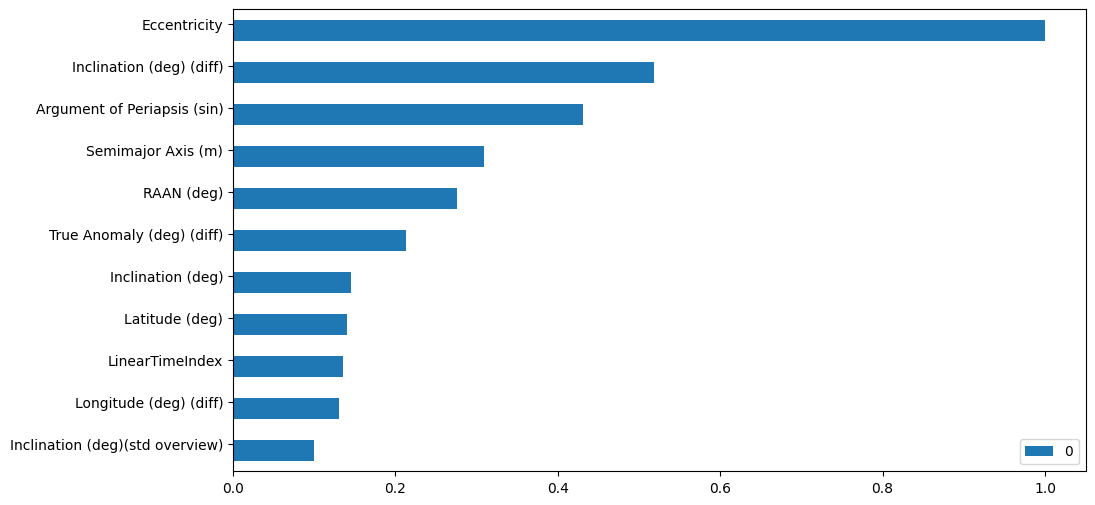

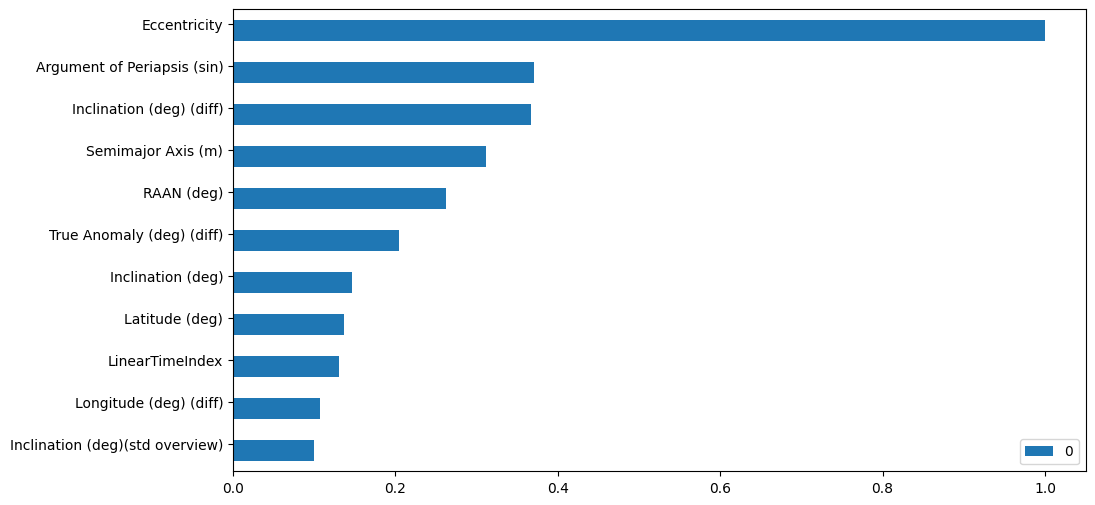

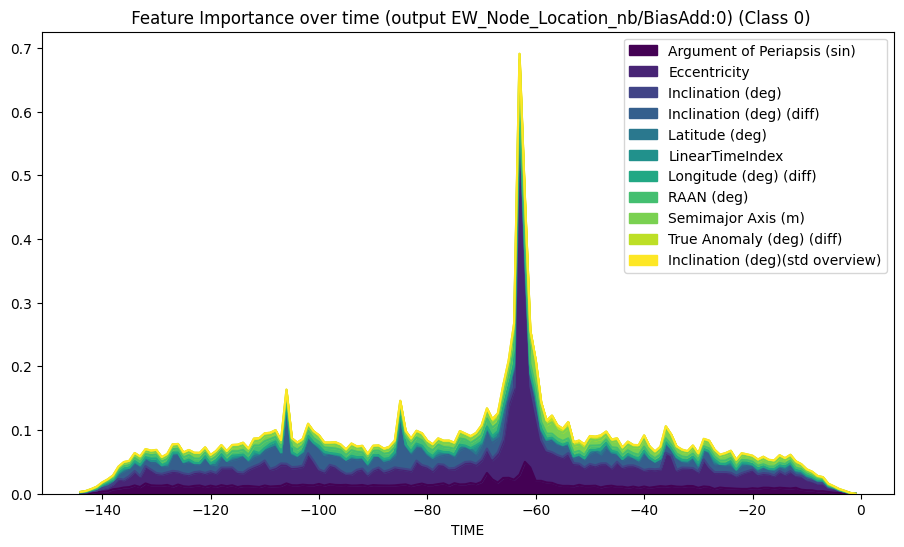

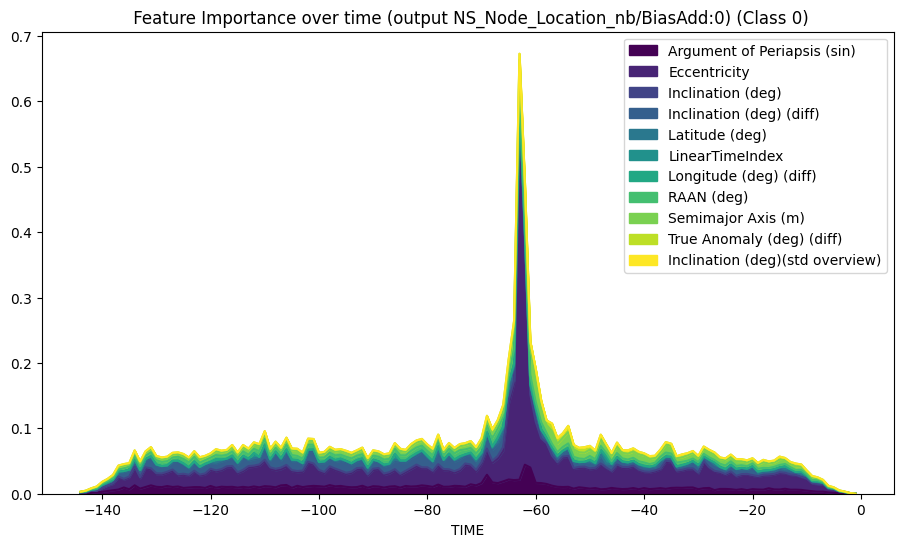

In [30]:
ft_cols = ds_gen._input_features + [ft+'(mean overview)' for ft in ds_gen._overview_features_mean] + [ft+'(std overview)' for ft in ds_gen._overview_features_std]
shap_analysis.plot_ft_importance_bars(shap_vals, ft_cols)
shap_analysis.plot_ft_importance_over_time(shap_vals, ft_cols)